# Class Activation Map Example

This example shows how to obtain the the CNN features, just before the dense layer, corresponding to the predicted class.

In [1]:
from __future__ import print_function, division
from builtins import range, input

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import utils

from glob import glob

import fiftyone as fo
import fiftyone.zoo as foz

tensorflow version: 2.8.0


In [2]:
# Show available datasets from the Fiftyone zoo
print(foz.list_zoo_datasets())

['activitynet-100', 'activitynet-200', 'bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kinetics-400', 'kinetics-600', 'kinetics-700', 'kinetics-700-2020', 'kitti', 'lfw', 'mnist', 'open-images-v6', 'quickstart', 'quickstart-geo', 'quickstart-video', 'ucf101', 'voc-2007', 'voc-2012']


In [3]:
# Define a dataset and download it
dataset = foz.load_zoo_dataset(
    "coco-2017",
    #split=('validation'),
    label_types=["detections"],
    classes=["person", "car", "truck"],
    max_samples=10
)

Found annotations at '/home/jarno/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/home/jarno/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Test split is unlabeled; ignoring classes requirement
Found test info at '/home/jarno/fiftyone/coco-2017/raw/image_info_test2017.json'
Sufficient images already downloaded
Existing download of split 'test' is sufficient
Loading 'coco-2017' split 'train'
 100% |███████████████████| 10/10 [77.2ms elapsed, 0s remaining, 129.5 samples/s]    
Loading 'coco-2017' split 'validation'
 100% |███████████████████| 10/10 [97.6ms elapsed, 0s remaining, 102.5 samples/s]     
Loading 'coco-2017' split 'test'
Dataset is unlabeled; ignoring classes requirement
 100% |███████████████████| 10/10 [13.2ms elapsed, 0s remaining, 757.9 samples/s]    
Dataset 'coco-2017-10' 

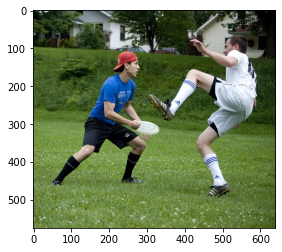

In [4]:
# Show an image from the dataset
image = utils.load_image(dataset.head(1)[0].filepath)
plt.imshow(image)
plt.show()

In [5]:
# Load a pre-trainet ResNet 50
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [6]:
# Capture the output of the net before the fully connected layer
activation_layer = resnet.get_layer('conv5_block3_out')

# Create a new model which outputs only the feature maps, i.e. without the fully connected layer
model = Model(inputs=resnet.input, outputs=activation_layer.output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [7]:
# Get the feature map (dense layer) weights
dense_layer = resnet.get_layer('predictions')
W = dense_layer.get_weights()[0]

print(f'Dense layer weights shape: {W.shape}')

Dense layer weights shape: (2048, 1000)


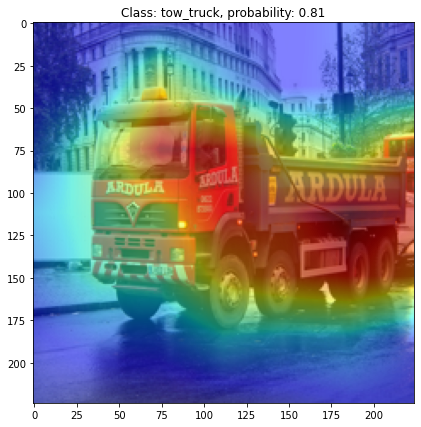

In [8]:
img_idx = 2
image = utils.load_image(dataset.head(10)[img_idx].filepath, target_size=(224, 224))
#print(f'Shape of the image: {image.shape}')

x = preprocess_input(np.expand_dims(image, 0))
#print(f'Shape of the inpout: {x.shape}')

# Get the feature maps
feature_maps = model.predict(x)[0]

# Predict the class using the original model
prediction_probabilities = resnet.predict(x)
classnames = decode_predictions(prediction_probabilities)[0][0]

prediction = np.argmax(prediction_probabilities)
w = W[:, prediction]

cam = feature_maps.dot(w)
cam = sp.ndimage.zoom(cam, (32, 32), order=1)

plt.figure(figsize = (7,7))
plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title(f'Class: {classnames[1]}, probability: {classnames[2]:2.2f}')
plt.show()